In [1]:
import tensorflow as tf
from utils import bbox_utils, data_utils, drawing_utils, io_utils, train_utils, eval_utils
from models.decoder import get_decoder_model
from helper import label_generator
from models.ssd_mobilenet_v2 import get_model, init_model
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [31]:
batch_size = 8
evaluate = False
backbone = 'mobilenet_v2'
io_utils.is_valid_backbone(backbone)

hyper_params = train_utils.get_hyper_params(backbone)
test_data, size_info = data_utils.get_dataset("test", dir_ = "F:\Minor Data Collection\Final Image Data\Monument Original\TFRecord\\")
# test_data, size_info = data_utils.get_dataset("test", dir_ = "F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented\\")
total_items = size_info

In [32]:
labels = label_generator.csv_to_label_map("helper\Report\ps-up-sp-BDS-alamy-merged.csv", 'list-type')
labels = ["bg"] + labels
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]

In [33]:
data_types = data_utils.get_data_types()
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()

In [34]:
test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))

In [22]:
# img_paths = data_utils.get_custom_imgs('./test_images')
# total_items = len(img_paths)
# test_data = tf.data.Dataset.from_generator(lambda: data_utils.custom_data_generator(
#                                            img_paths, img_size, img_size), data_types, data_shapes)

In [35]:
test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [24]:
# ssd_model = get_model(hyper_params)
# ssd_model_path = io_utils.get_model_path(backbone)
# ssd_model.load_weights(ssd_model_path)

In [25]:
# prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
# ssd_decoder_model = get_decoder_model(ssd_model, prior_boxes, hyper_params)

In [26]:
# ssd_decoder_model = tf.keras.models.load_model('./MobileNetv2_SSD.h5')
# ssd_decoder_model.save('MobileNetV2_SSD_SavedModel')

In [27]:
# saving tensorflowlite model
# converter = tf.lite.TFLiteConverter.from_saved_model('MobileNetV2_SSD_SavedModel')
# tflite_model = converter.convert()
# with open('model.tflite', wb) as f:
#     f.write(tflite_model)

In [36]:
from models import header
ssd_mobilenet_model = tf.keras.models.load_model("MobileNetV2_SSD_SavedModel", custom_objects={
    "HeadWrapper": header.HeadWrapper
})

In [37]:
step_size = train_utils.get_step_size(total_items, batch_size)
pred_bboxes, pred_labels, pred_scores = ssd_mobilenet_model.predict(test_data, steps=step_size, verbose=1)

45/45 [==============================] - 26s 534ms/step


In [38]:
stats = eval_utils.evaluate_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)

mAP: 0.8383434237216918


In [30]:
print(stats)

{1: {'label': 'badrinath temple', 'total': 73, 'tp': [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1], 'fp': [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], 'scores': [0.99980885, 0.99993336, 0.98567086, 0.8323462, 0.951837, 0.8870905, 0.999979, 0.9994029, 0.9725104, 0.99985385, 0.9999486, 0.9999757, 0.9999902, 0.99998605, 0.99991083, 0.8351183, 0.7876818, 0.9713777, 0.9971405, 0.86627406, 0.99980205, 0.9999696, 0.9999832, 0.9999862, 0.9998851, 0.99998665, 0.9956862, 0.9998821, 0.99982834, 0.97042143, 0.99999774, 0.9983204, 0.99998534, 0.9949669, 0.9999896, 0.9999758, 0.999987, 0.99999785, 0.99999774, 0.9999987, 0.9999527, 0.99924266, 0.99999416, 0.9999877, 0.9999893, 0.9999515, 0.9995492, 0.7949861, 0.99886715, 0.9999044, 0

In [16]:
# drawing_utils.draw_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)

In [54]:
filenames_list = list()
for filename in os.listdir('./test_images'):
    filenames_list.append(filename)
total_items = len(filenames_list)
img_pred_bboxes = list()
img_pred_labels = list()
img_pred_scores = list()
output_dict = {}
for i in range(total_items):
    image_path = os.path.join('test_images', filenames_list[i])
    image = Image.open(image_path)
    height, width = image.size
    count = 0
    temp_pred_bboxes = list()
    temp_pred_labels = list()
    temp_pred_scores = list()
    for bbox_list in pred_bboxes[i]:
        if bbox_list[0] > 0 or bbox_list[1] > 0:
            count += 1
            y1 = int(bbox_list[0] * height)
            x1 = int(bbox_list[1] * width)
            y2 = int(bbox_list[2] * height)
            x2 = int(bbox_list[3] * width)
            temp_pred_bboxes.append([y1, x1, y2, x2])
    for j in range(count):
        temp_pred_labels.append(labels[int(pred_labels[i][j])])
        temp_pred_scores.append(pred_scores[i][j])
    
    temp = dict()
    temp['image_path'] = image_path
    temp['bboxes'] = temp_pred_bboxes
    temp['labels'] = temp_pred_labels
    temp['scores'] = temp_pred_scores
    output_dict[filenames_list[i]] = temp
    img_pred_scores.append(temp_pred_scores)
    img_pred_labels.append(temp_pred_labels)
    img_pred_bboxes.append(temp_pred_bboxes)
# print(output_dict)

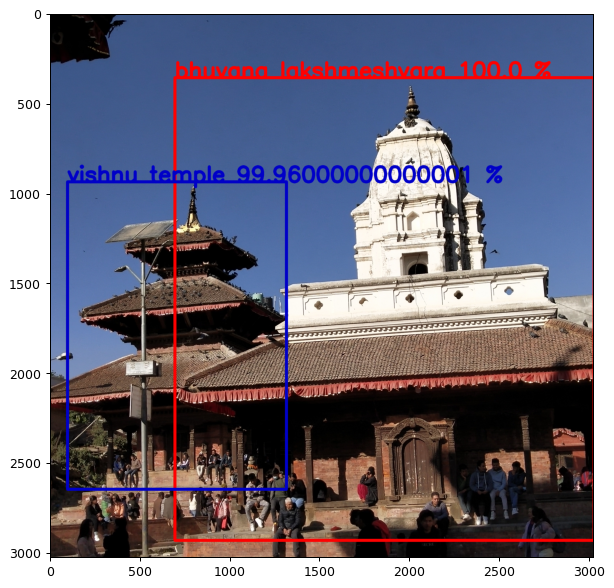

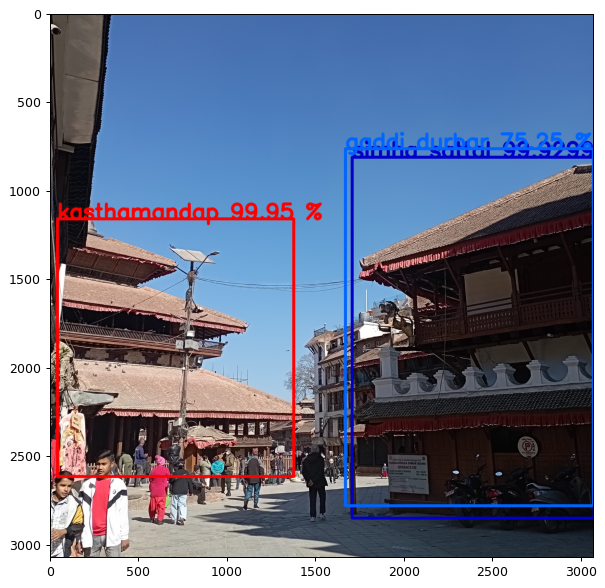

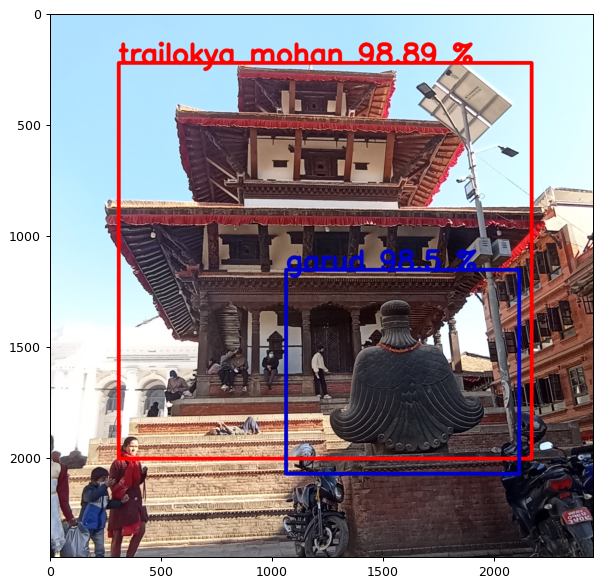

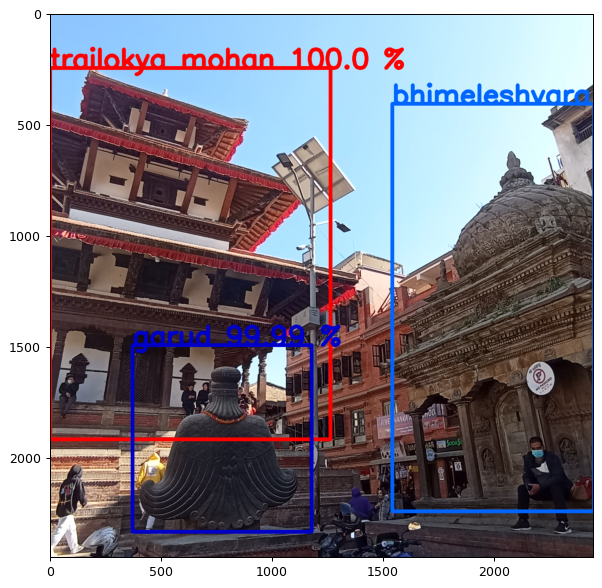

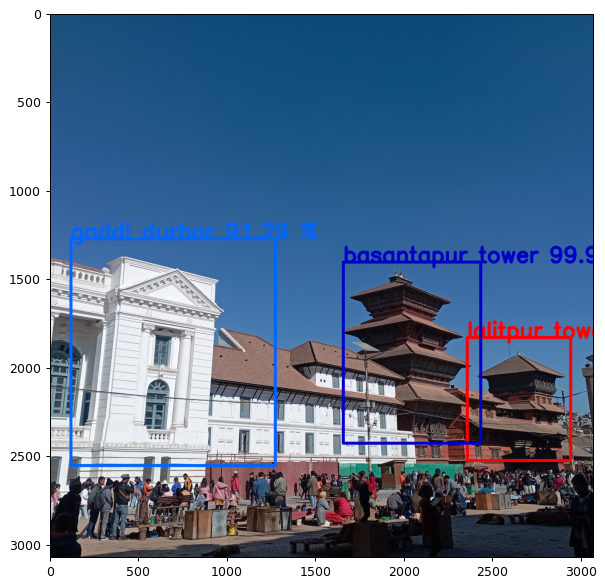

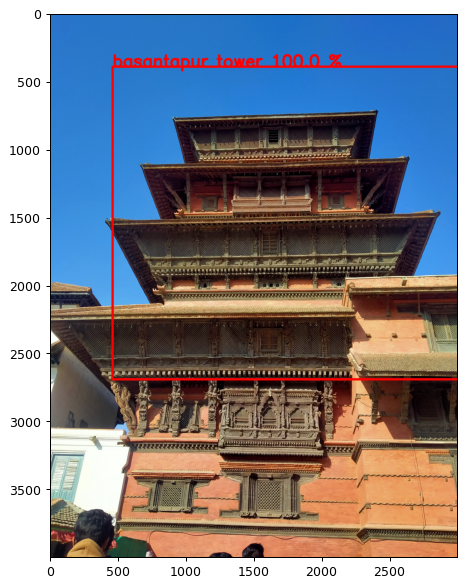

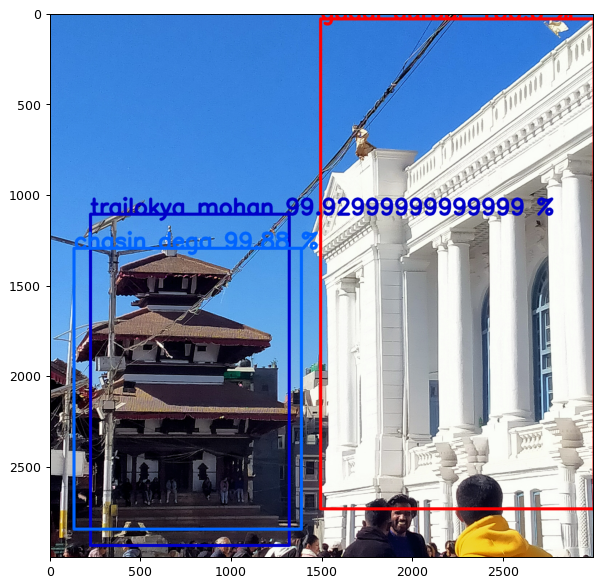

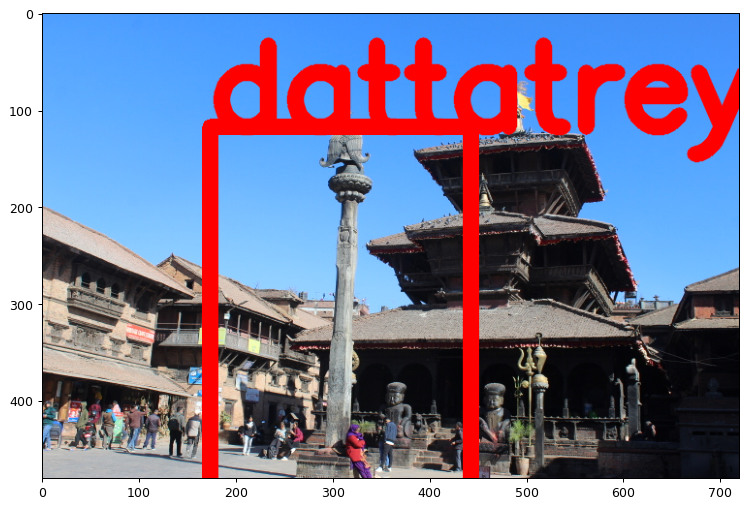

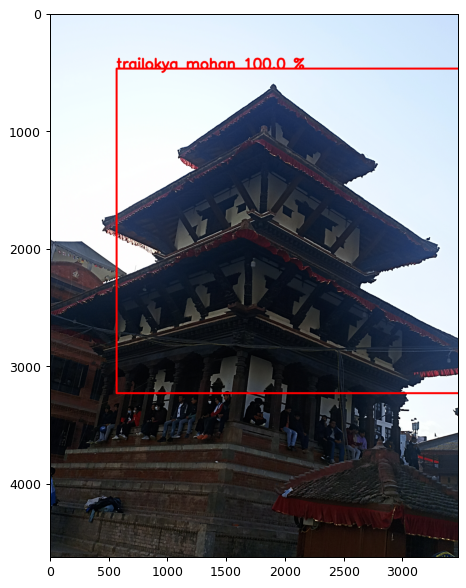

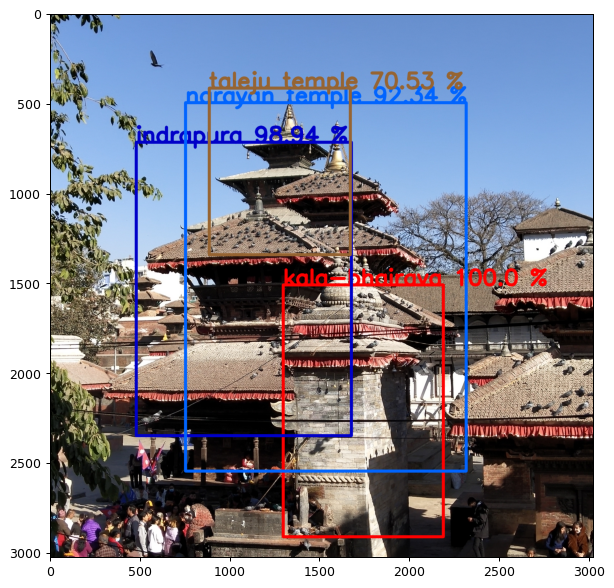

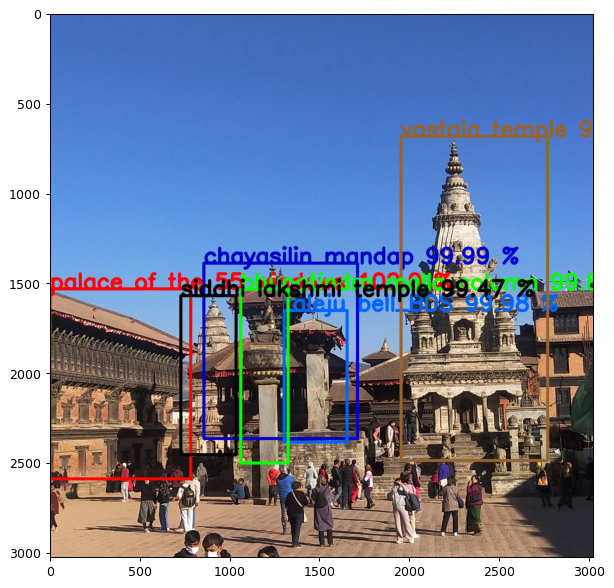

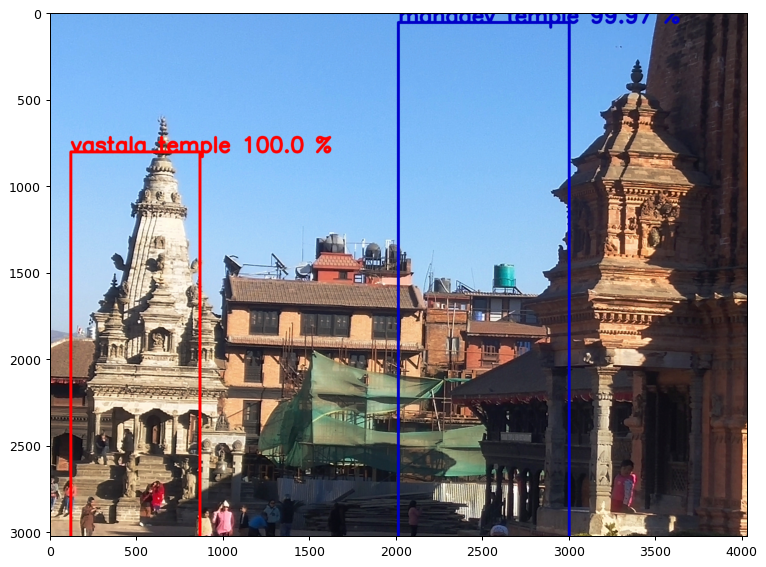

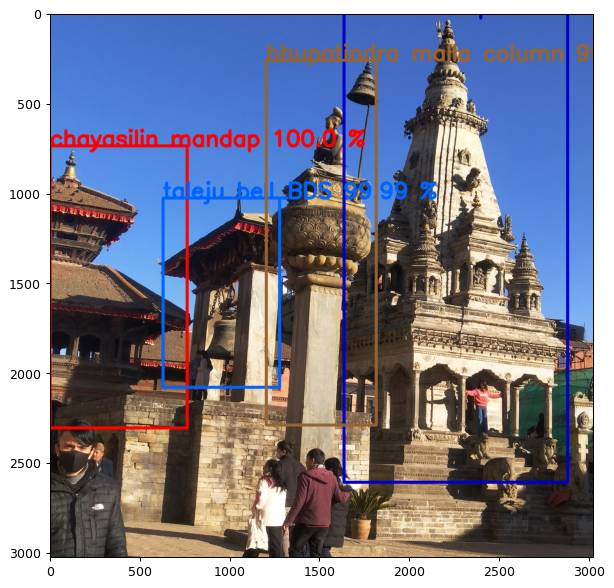

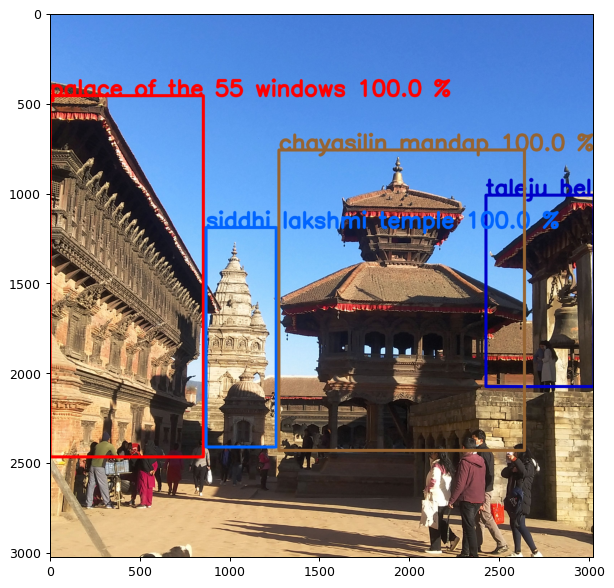

In [65]:
colors = [(0, 0, 255), (200 , 0, 0), (255, 100, 0), (50, 100, 150), (0, 255, 0), (0, 0, 0), (125, 148, 255)]
for key, value in output_dict.items():
    img = cv2.imread(value['image_path'])
    for i in range(len(value['bboxes'])):
        label = value['labels'][i]
        predicted_score = "%.4f" % value['scores'][i]
        label = label + " " + str(float(predicted_score) * 100) + " %"
        cv2.rectangle(img, (value['bboxes'][i][1], value['bboxes'][i][0]), (value['bboxes'][i][3], value['bboxes'][i][2]), color = colors[i], thickness = 15)
        cv2.putText(img, label, (value['bboxes'][i][1], value['bboxes'][i][0]), cv2.FONT_HERSHEY_SIMPLEX, 4, colors[i], 15, cv2.LINE_AA)
    plt.figure(figsize = (10, 8), dpi = 90)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.savefig('./test_images/new_'+ key, dpi = 240)
    plt.show()

In [37]:
label = labels[int(pred_labels[0][0])]
predicted_score = "%.4f" % pred_scores[0][0]
label = label + " " + str(float(predicted_score) * 100) + " %"

In [38]:
img = cv2.imread('test_images\IMG20230122143048.jpg')
cv2.rectangle(img, (x1, y1 + 10), (x2, y2), color = (0, 0, 255), thickness = 15)
cv2.putText(img, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 0), 15, cv2.LINE_AA)
# cv2.imwrite("bounding.jpg", img)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [102, 108, 103],
        [105, 110, 108],
        [103, 108, 106]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [102, 108, 103],
        [107, 110, 108],
        [105, 108, 106]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [103, 107, 102],
        [108, 106, 105],
        [109, 105, 104]],

       ...,

       [[ 30,  68,  46],
        [ 37,  64,  44],
        [ 56,  61,  46],
        ...,
        [ 34,  24,  17],
        [ 29,  23,  18],
        [ 24,  21,  16]],

       [[  9, 144,  76],
        [ 31, 133,  75],
        [ 33,  66,  32],
        ...,
        [ 38,  23,  20],
        [ 34,  23,  19],
        [ 28,  19,  15]],

       [[  0, 158,  66],
        [  7, 147,  70],
        [ 24,  70,  27],
        ...,
        [ 45,  30,  28],
        [ 40,  25,  22],
        [ 30,  18,  14]]

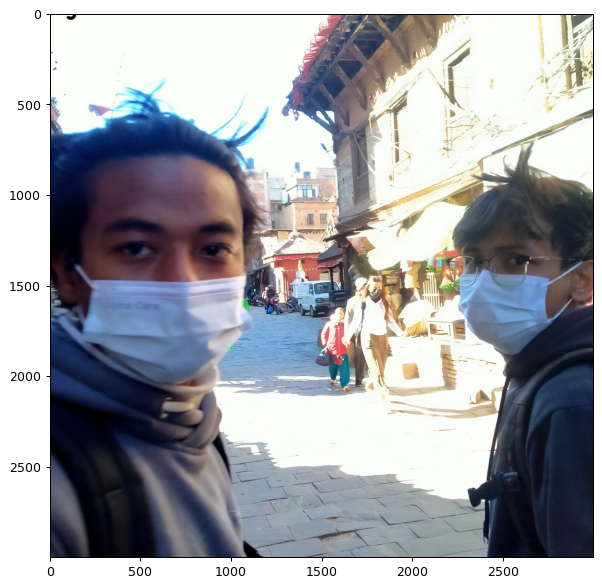

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8), dpi = 90)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.axis('off')
plt.show()